In [ ]:
#install the nltools module
!pip install nltools

In [ ]:
#install all modules required to perform ISC, ISRA, functional hyperalignment analyses
%matplotlib inline

import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length, fisher_r_to_z, correlation_permutation
from nilearn.plotting import view_img_on_surf, view_img, plot_glass_brain, plot_stat_map
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp, rankdata, ttest_rel
from scipy.signal import hilbert
from sklearn.manifold import TSNE
import networkx as nx
from IPython.display import HTML
from nilearn import plotting
from nilearn import signal
from nilearn import regions
import nibabel as nib


In [ ]:
#time of low emotion segment including haemodynamic lag
time = 1.24 - 2.51
timepoint = range(43, 87)

#time of high emotion segment including haemodynamic lag
time = 2.51 - 4.18
timepoint = range(88, 132)


In [ ]:
#read the timeseries of all participants into a 3D array

data_dir = np.sort(glob.glob('/content/drive/MyDrive/Year2/NARSAD3/*_task-thepresent_nuisance_regressed_shen_2mm_268.txt'))
sub_list = [os.path.basename(x).split('_')[0] for x in data_dir]

timeseries_part1 = []
timeseries_part2 = []
sub_timeseries = {}

for filename in data_dir:

  shen = np.loadtxt(filename)
  shen_part1_df = pd.DataFrame(shen[43:87, :])
  shen_part1_df.reset_index(inplace = True, drop = True)
  shen_part1_df_to_array = shen_part1_df.to_numpy()
  timeseries_part1.append(shen_part1_df_to_array)

  shen_part2_df = pd.DataFrame(shen[88:, :])
  shen_part2_df.reset_index(inplace = True, drop = True)
  shen_part2_df_to_array = shen_part2_df.to_numpy()
  timeseries_part2.append(shen_part2_df_to_array)

timeseries_part1_3D = np.array(timeseries_part1)
timeseries_part2_3D = np.array(timeseries_part2)


In [ ]:
#convert the timeseries of all participants to a dataframe

timeseries_part1_reg = {}
timeseries_part2_reg = {}

for sub in range(timeseries_part1_3D.shape[0]):

  timeseries_part1_reg[sub] = pd.DataFrame(timeseries_part1_3D[sub, :, :])
  timeseries_part2_reg[sub] = pd.DataFrame(timeseries_part2_3D[sub, :, :])
  

In [ ]:
#standardise the timeseries by z-transforming the timesries and store it in a dataframe

standardise_part1_df = {}
timeseries_part1_reg = {}

standardise_part2_df = {}
timeseries_part2_reg = {}

for sub in range(timeseries_part1_3D.shape[0]):

  standardise_part1_df[sub] = signal.clean(timeseries_part1_3D[sub, :, :], detrend = False, standardize = 'zscore', standardize_confounds = False, t_r = None)
  timeseries_part1_reg[sub] = pd.DataFrame(standardise_part1_df[sub])

  standardise_part2_df[sub] = signal.clean(timeseries_part2_3D[sub, :, :], detrend = False, standardize = 'zscore', standardize_confounds = False, t_r = None)
  timeseries_part2_reg[sub] = pd.DataFrame(standardise_part2_df[sub])
  

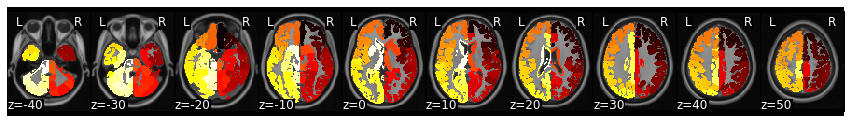

In [ ]:
#load the Shen 268 parcellation as a mask
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)
mask.plot()


In [ ]:
timeseries_part1_ISRA = []
timeseries_part2_ISRA = []

for sub in range(len(sub_list)):

  timeseries_part1_ISRA_to_array = timeseries_part1_reg[sub].to_numpy()
  timeseries_part1_ISRA.append(timeseries_part1_ISRA_to_array)

  timeseries_part2_ISRA_to_array = timeseries_part2_reg[sub].to_numpy()
  timeseries_part2_ISRA.append(timeseries_part2_ISRA_to_array)

timeseries_part1_ISRA = np.array(timeseries_part1_ISRA)
timeseries_part2_ISRA = np.array(timeseries_part2_ISRA)


n_subs, n_ts, n_nodes = timeseries_part1_ISRA.shape


In [ ]:
#compute the similarity matrices using adjacency matrices between pairs of participants

similarity_part1_matrices = []
similarity_part2_matrices = []
similarity_diff_matrices = []

for node in range(n_nodes):
  
  similarity_part1_matrices.append(Adjacency(1 - pairwise_distances(timeseries_part1_ISRA[:, :, node], metric = 'correlation'), matrix_type = 'similarity'))
  similarity_part2_matrices.append(Adjacency(1 - pairwise_distances(timeseries_part2_ISRA[:, :, node], metric = 'correlation'), matrix_type = 'similarity'))

for roi in range(n_nodes):

  #similarity_diff_matrices.append(similarity_part1_matrices[roi] - similarity_part2_matrices[roi])
  similarity_diff_matrices.append(similarity_part2_matrices[roi] - similarity_part1_matrices[roi])

similarity_diff_matrices = Adjacency(similarity_diff_matrices)


In [ ]:
stats = {node:similarity_diff_matrices[node].isc(metric = 'mean', n_bootstraps = 5000, n_jobs = 1) for node in range(n_nodes)}
isc_r = [stats[node]['isc'] for node in range(n_nodes)]
isc_p = [stats[node]['p'] for node in range(n_nodes)]

keys = np.arange(n_nodes)
isc_r = dict(zip(keys, isc_r))
isc_p = dict(zip(keys, isc_p))

isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_r), mask_x), roi_to_brain(pd.Series(isc_p), mask_x)


/usr/local/lib/python3.7/dist-packages/nltools/stats.py:460: RuntimeWarning: invalid value encountered in arctanh
  return np.arctanh(r)



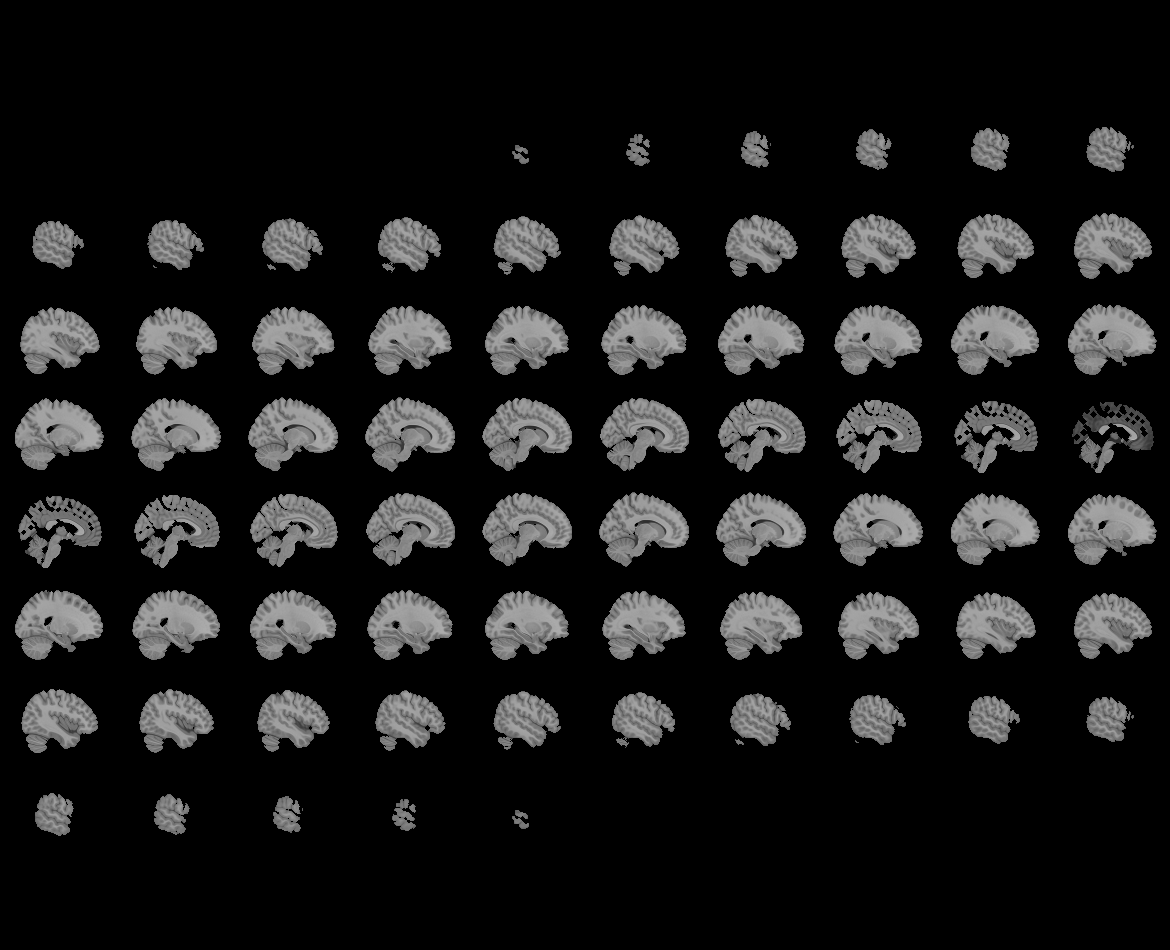
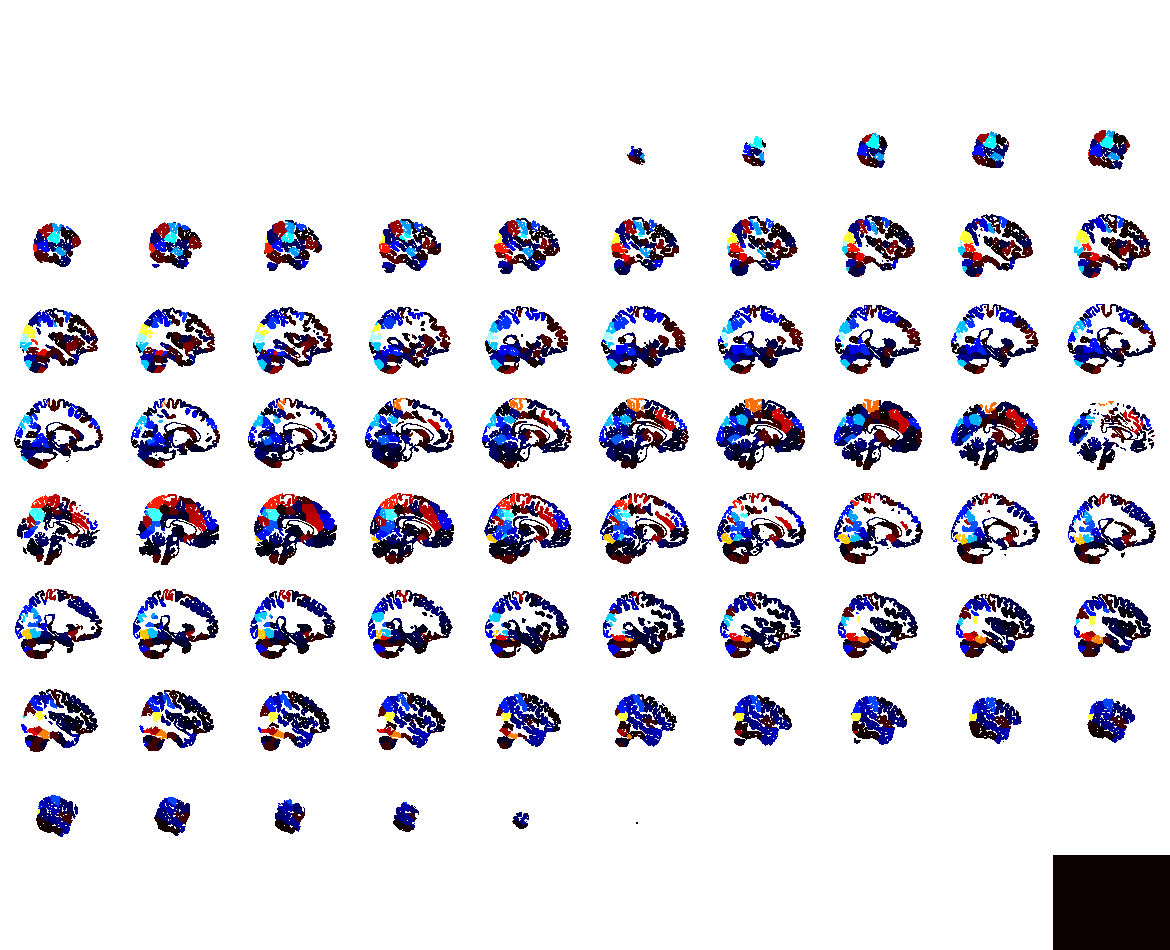

In [ ]:
view_img(isc_r_brain.to_nifti())


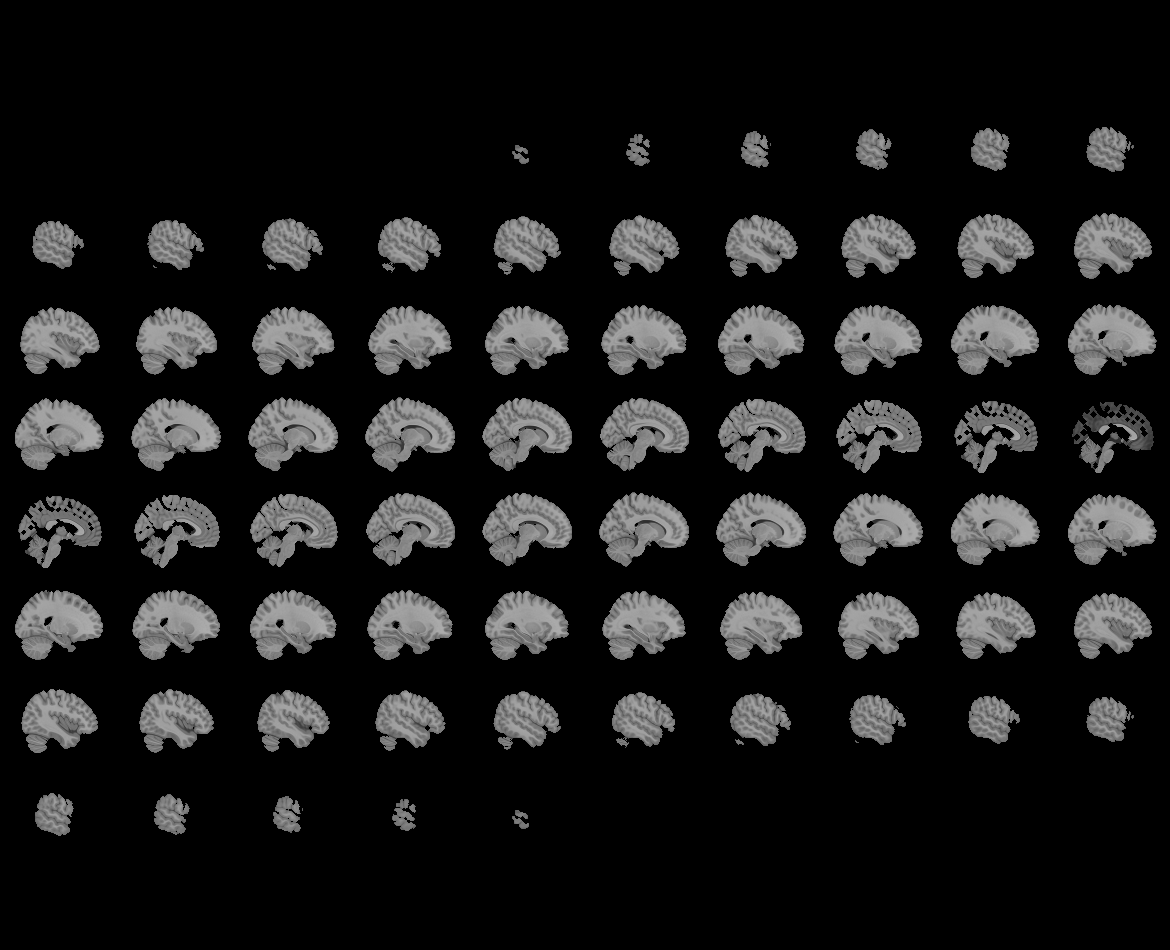
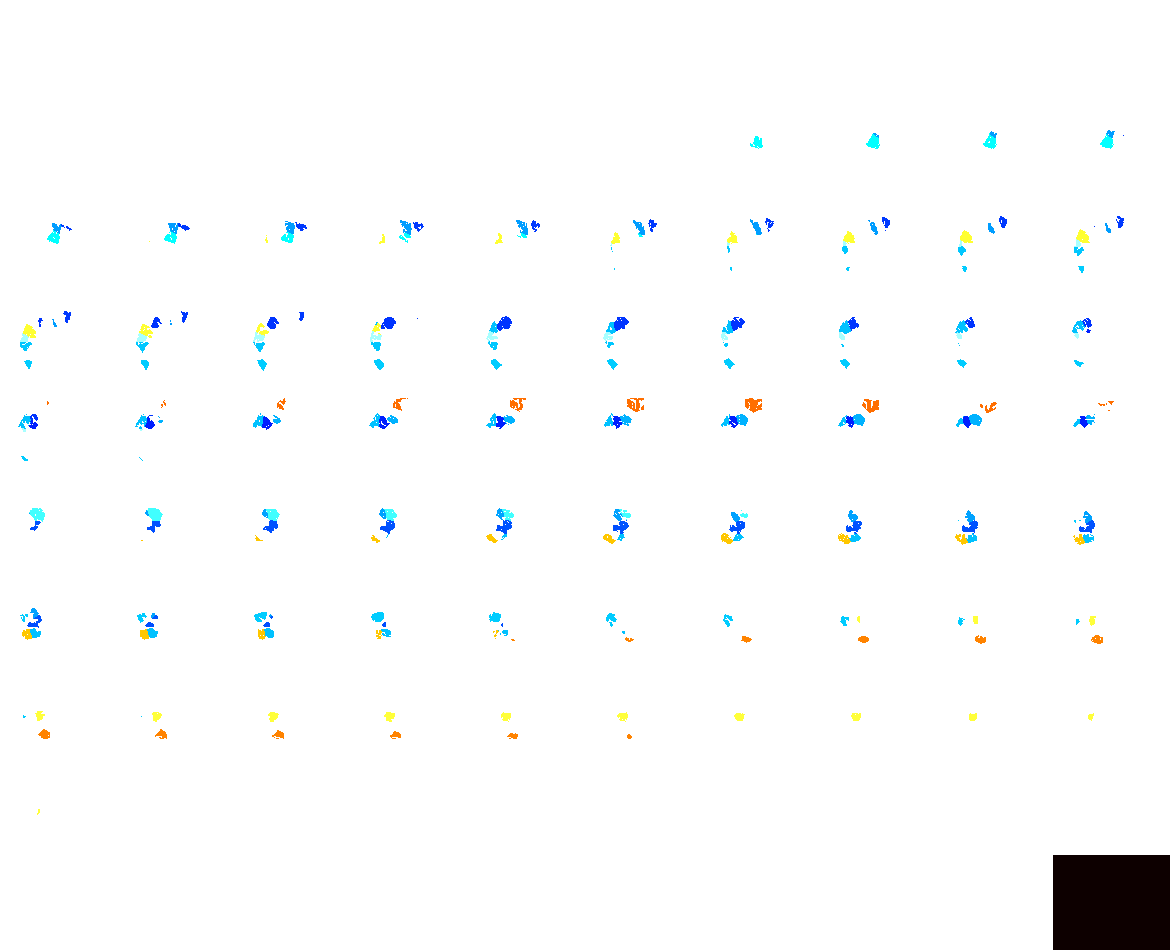

In [ ]:
fdr_thr = fdr(pd.Series(isc_p).values)
view_img(threshold(isc_r_brain, isc_p_brain, thr = fdr_thr).to_nifti())

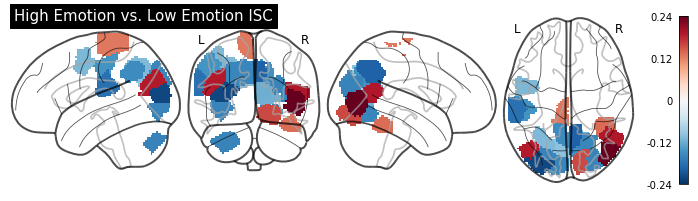

In [ ]:
plotting.plot_glass_brain(threshold(isc_r_brain, isc_p_brain, thr = fdr_thr).to_nifti(), colorbar = True, plot_abs = False, display_mode = 'lyrz', cmap = 'RdBu_r', title = 'High Emotion vs. Low Emotion ISC')


In [ ]:
import nibabel as nib
nib.save(threshold(isc_r_brain, isc_p_brain, thr = fdr_thr).to_nifti(), '/content/drive/MyDrive/Year2/emotion_segment.nii.gz')


In [ ]:
#count parcels that survive FDR correction
np.sum(pd.Series(isc_p).values <= fdr(isc_p_brain.data))


39